In [ ]:
## import packages
import os
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL
import PIL.Image
import cv2

import warnings
warnings.filterwarnings("ignore")

# Import functions from Kaggle example code:

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(16,16))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        # plt.xticks([]); 
        # plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        
        if type(image) == str:
            image = mpimg.imread(image)
        
        plt.imshow(image)
    plt.show()


# See https://stackoverflow.com/questions/43884463/how-to-convert-rgb-image-to-one-hot-encoded-3d-array-based-on-color-using-numpy
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr


def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)


## Classes and their respective pixel values
class_dict_pd = pd.read_csv('{}/class_dict.csv'.format(path))
class_names = class_dict_pd['name'].values.tolist()
class_rgb_vals = class_dict_pd[['r', 'g', 'b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_vals)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_vals)

import os
import pandas as pd
import numpy as np

# Define path to the data
path = r"C:\Users\Cherith\Desktop\DIP PRO\archive"

# Load class dictionary
class_dict_pd = pd.read_csv(os.path.join(path, 'class_dict.csv'))
class_names = class_dict_pd['name'].values.tolist()
class_rgb_vals = class_dict_pd[['r', 'g', 'b']].values.tolist()

# Useful to shortlist specific classes in datasets with a large number of classes
select_classes = class_names  # Modify this list if specific classes need to be selected

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_vals)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_vals)



# Create a dictionary for One-Hot Encoding
class_dict =  dict(zip(select_class_indices, class_rgb_vals))
class_dict



# Load metadata file - contains relative paths for images and masks
metadata = pd.read_csv(os.path.join(path, 'metadata.csv'))

# Preparing metadata for use
# Filter out images that do not have masks (those images are part of the challenge set)
metadata = metadata[metadata['split'] == 'train']  

# Retain only relevant columns
metadata = metadata[['image_id', 'sat_image_path', 'mask_path']]

# Set paths to absolute paths rather than relative paths
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata['mask_path'] = metadata['mask_path'].apply(lambda img_pth: os.path.join(path, img_pth))

print("Processed Metadata:")
print(metadata.head())


 metadata.sort_values('image_id')

img_Loc = metadata['sat_image_path'][1]
mask_Loc = metadata['mask_path'][1]

img = cv2.imread(img_Loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

visualize(Image = img, Mask = mask_Loc)

# Indentify the number of satellite images and corresponding masks
numSatImg = len(metadata['sat_image_path'])
numMask = len(metadata['mask_path'])
print("Number of original satellite images: " + str(numSatImg))
print("Number of original masks: " + str(numMask))

# Open example image & mask
img = PIL.Image.open(metadata['sat_image_path'][0])
mask = PIL.Image.open(metadata['mask_path'][0])
# Get dimensionality of that image & mask
numPixels = np.asarray(img).shape
numMaskPx = np.asarray(mask).shape
print('Number of pixels in each image: {}'.format(numPixels))
print('Number of pixels in each masks: {}'.format(numMaskPx))


# Initialize arrays for cropped sat images and masks
# First we will need to trim the 2448 x 2448 image to 2048 x 2048 image so that it can be used with U-net 
# which needs to have images with sizes divisible by 32
# We will then crop each image down to sections of 128 x 128 x 3, which produces 256 cropped images per original sat image.
# If you want to change the size of the cropped image, change the denominator for cropimg width / height below

cropImg_height = int((numPixels[0]-400) / 4) # 2048 / 4 = 512
cropImg_width = int((numPixels[1]-400) / 4) # 2048 / 4 = 512

X = np.zeros([(numSatImg * 16), cropImg_height, cropImg_width, numPixels[2]], dtype='uint8')
y = np.zeros([(numMask * 16), cropImg_height, cropImg_width, len(class_dict)], dtype='uint8')
print('Shape of cropped sat image dataset: {}'.format(X.shape))
print('Shape of cropped mask dataset: {}'.format(y.shape))

# Extract paths from pandas df to np array for iteration purposes - don't want to use iterrows b/c its slow!
Xrows = np.asarray(metadata['sat_image_path'])
yrows = np.asarray(metadata['mask_path'])

# Step 0: Trim images from 2448x2448 to 2048x24048 to make the image size divisible by 32 for Unet purposes
# Step 1: Iterate through image & corresponding mask paths and read images into memory
# Step 2: iterate through original img matrix and crop to predefined crop height & width
# Step 3: Save cropped matrix to working dataset

cropImgIdx = 0

# for i in range(0, len(Xrows)):
for i in range(0, 200):
  
  # Read and normalize image
  img = np.asarray(cv2.imread(Xrows[i]))
  mask = np.asarray(cv2.imread(yrows[i]))
  
  # Trim image to [2048,2048,3] by trimming extra 200px off from the border
  img = np.array(img[200:2248, 200:2248, :])
  mask = np.array(mask[200:2248, 200:2248, :])

  # Iterate through each row
  for r in range(0, img.shape[0], cropImg_height):
    # Iterate through each column
    for c in range(0, img.shape[1], cropImg_width):

      # Slice mask by cropping window first
      # That way we can check if if we're going to use the image or not
      newMask = np.array(mask[r:r+cropImg_height, c:c+cropImg_width, :])
      newMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2RGB)
      
      # Convert mask to grayscale to find distribution of classes
      grayMask = cv2.cvtColor(newMask, cv2.COLOR_BGR2GRAY)
      # Get frequency of each classification in the cropped mask
      unique, frequency = np.unique(grayMask, return_counts= True)
      frequency = frequency / (len(grayMask.flatten()))

      # Check if any classes are represent 99% of image
      # If that is the case, throw it out
      if (frequency >= 0.99).any():
        continue

      # Try one-hot encoding of mask here
      newMask = rgb_to_onehot(newMask, class_dict)

      # Crop image if we make it past the majority class checker
      newImg = np.array(img[r:r+cropImg_height, c:c+cropImg_width, :])
      newImg = cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)

      X[cropImgIdx,:] = newImg
      y[cropImgIdx,:] = newMask

      cropImgIdx += 1

print('There were {} images cropped from {} original images'.format((cropImgIdx-1), numSatImg))

 cropImgIdx -= 1

X = X[0:cropImgIdx, :,:,:]
y = y[0:cropImgIdx, :,:,:]

print(X.shape)
print(y.shape)


ogImg = Xrows[0]
ogmask = yrows[0]
cropImg = X[0]
cropMsk = onehot_to_rgb(y[0], class_dict)

visualize(original_Image = ogImg, original_Mask = ogmask)
visualize(crop_Image = cropImg, crop_Mask = cropMsk)



Using device: cuda


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/cherry/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100.0%
/tmp/ipykernel_2190/108497773.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_2190/108497773.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_2190/108497773.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Train Loss: 1.5842, Val Loss: 1.1933
Epoch 2/20, Train Loss: 1.0950, Val Loss: 0.8740
Epoch 3/20, Train Loss: 0.9733, Val Loss: 0.8293
Epoch 4/20, Train Loss: 0.8427, Val Loss: 0.7713
Epoch 5/20, Train Loss: 0.7388, Val Loss: 0.6696
Epoch 6/20, Train Loss: 0.6937, Val Loss: 0.6357
Epoch 7/20, Train Loss: 0.6059, Val Loss: 0.6228
Epoch 8/20, Train Loss: 0.5465, Val Loss: 0.6139
Epoch 9/20, Train Loss: 0.5095, Val Loss: 0.5697
Epoch 10/20, Train Loss: 0.5112, Val Loss: 0.6255
Epoch 11/20, Train Loss: 0.4527, Val Loss: 0.5804
Epoch 12/20, Train Loss: 0.4587, Val Loss: 0.5402
Epoch 13/20, Train Loss: 0.4190, Val Loss: 0.5655
Epoch 14/20, Train Loss: 0.3760, Val Loss: 0.5439
Epoch 15/20, Train Loss: 0.3586, Val Loss: 0.5345
Epoch 16/20, Train Loss: 0.3307, Val Loss: 0.5442
Epoch 17/20, Train Loss: 0.3156, Val Loss: 0.5448
Epoch 18/20, Train Loss: 0.2853, Val Loss: 0.5101
Epoch 19/20, Train Loss: 0.2936, Val Loss: 0.5366
Epoch 20/20, Train Loss: 0.2826, Val Loss: 0.5074


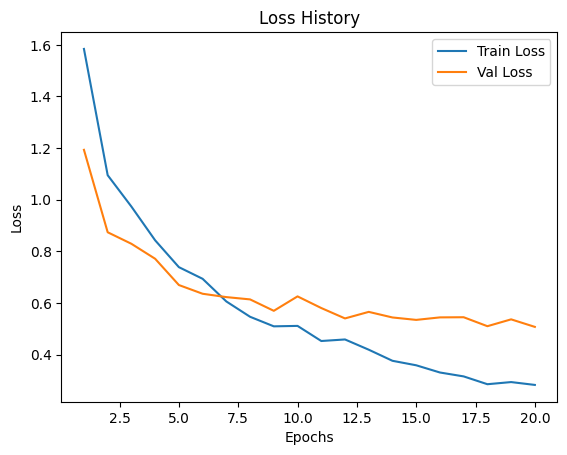

Model saved to /home/cherry/dip_assig/archive/deeplabv3_model.pth


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import cv2
import matplotlib.pyplot as plt

# Dataset path
data_path = "/home/cherry/dip_assig/archive"

# Load metadata
metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
metadata = metadata[metadata['split'] == 'train']  # Use only training data
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda x: os.path.join(data_path, x))
metadata['mask_path'] = metadata['mask_path'].apply(lambda x: os.path.join(data_path, x))

# Load class dictionary
class_dict_pd = pd.read_csv(os.path.join(data_path, 'class_dict.csv'))
class_names = class_dict_pd['name'].values.tolist()
class_rgb_vals = class_dict_pd[['r', 'g', 'b']].values.tolist()
class_dict = dict(enumerate(class_rgb_vals))

# RGB to One-Hot Encoding function
def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    onehot = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        onehot[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return onehot

# Dataset class with reduced resolution
class SatelliteDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.metadata['sat_image_path'].iloc[idx]
        mask_path = self.metadata['mask_path'].iloc[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256)) / 255.0  # Resize to 256x256 and normalize
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))  # Resize mask to 256x256

        # Convert mask to one-hot encoding
        mask = rgb_to_onehot(mask, class_dict)

        # Convert to float32
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, mask

# Data transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Split metadata into train and validation sets
train_split = int(0.8 * len(metadata))
train_metadata = metadata.iloc[:train_split]
val_metadata = metadata.iloc[train_split:]

# Create datasets and data loaders
train_dataset = SatelliteDataset(train_metadata, transform=data_transforms)
val_dataset = SatelliteDataset(val_metadata, transform=data_transforms)

# DataLoader with pin_memory to optimize GPU transfers
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained DeepLabv3+ with ResNet-50 backbone to reduce memory usage
model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, len(class_dict), kernel_size=1)  # Adjust output classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Enable mixed precision training
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Training function with gradient accumulation and mixed precision
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, accumulation_steps=4):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device).float()
            masks = masks.permute(0, 3, 1, 2).argmax(dim=1).to(device)

            with autocast():
                outputs = model(images)['out']
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()

            # Perform optimizer step after accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device).float()
                masks = masks.permute(0, 3, 1, 2).argmax(dim=1).to(device)

                with autocast():
                    outputs = model(images)['out']
                    loss = criterion(outputs, masks)

                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

# Train the model
num_epochs = 20
train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Plot loss history
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss History")
plt.show()

# Save the model
model_path = os.path.join(data_path, "deeplabv3_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


In [10]:
# Identify unique labels in the ground truth and predicted masks
ground_truth_labels = np.unique(np.argmax(ground_truth, axis=-1))
predicted_labels = np.unique(predicted_mask)

# Map class indices to labels
ground_truth_class_names = [class_names[label] for label in ground_truth_labels]
predicted_class_names = [class_names[label] for label in predicted_labels]

# Print the labels
print("Ground Truth Labels:")
print(", ".join(ground_truth_class_names))

print("Predicted Labels:")
print(", ".join(predicted_class_names))


Ground Truth Labels:
urban_land, agriculture_land, rangeland, forest_land, water, barren_land
Predicted Labels:
rangeland, forest_land, barren_land


/tmp/ipykernel_2190/3296718680.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Original Image Shape: torch.Size([3, 256, 256])
Tensor Shape for Model Input: torch.Size([1, 3, 256, 256])


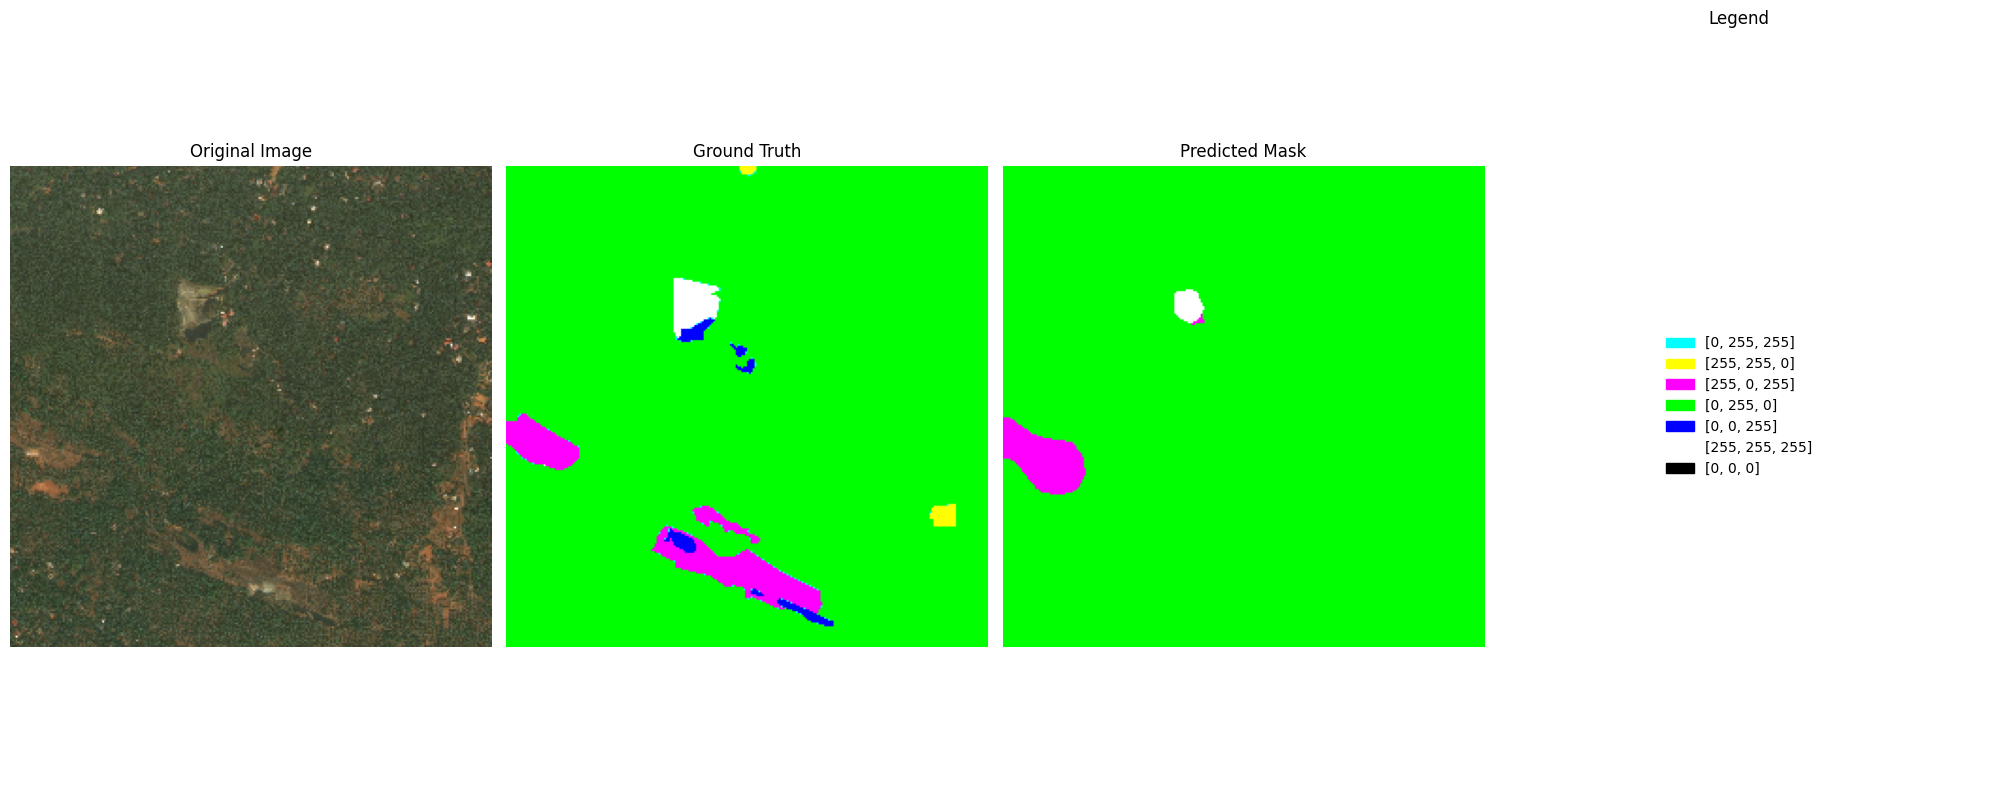

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Patch

# Helper function to convert one-hot encoded masks to RGB
def onehot_to_rgb(onehot, color_dict):
    """
    Convert one-hot encoded mask to RGB mask.
    """
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2] + (3,), dtype=np.uint8)
    for k in color_dict.keys():
        output[single_layer == k] = color_dict[k]
    return output

# Visualization function with legend
def visualize_comparison(original_image, ground_truth, predicted_mask, class_dict):
    """
    Visualize original image, ground truth, and predicted mask side by side.
    Display a legend mapping class labels to their colors.
    """
    ground_truth_rgb = onehot_to_rgb(ground_truth, class_dict)
    predicted_rgb = onehot_to_rgb(predicted_mask, class_dict)
    
    plt.figure(figsize=(20, 8))
    
    # Original image
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_rgb)
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_rgb)
    plt.axis("off")
    
    # Legend
    legend_patches = [Patch(color=np.array(color) / 255.0, label=label) 
                      for label, color in zip(class_dict.values(), class_dict.values())]
    plt.subplot(1, 4, 4)
    plt.title("Legend")
    plt.axis("off")
    plt.legend(handles=legend_patches, loc='center', fontsize=10, frameon=False)

    plt.tight_layout()
    plt.show()

# Path to the trained model and class dictionary
data_path = "/home/cherry/dip_assig/archive"
model_path = os.path.join(data_path, "deeplabv3_model.pth")

# Load the trained model
from torchvision import models
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = torch.nn.Conv2d(256, len(class_dict), kernel_size=1)  # Adjust for num_classes
model.load_state_dict(torch.load(model_path))
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Select an image and its ground truth from the validation dataset
dataset_idx = 0  # Index of the image in the validation dataset
image, ground_truth = val_dataset[dataset_idx]

# Check the original image shape
print("Original Image Shape:", image.shape)  # Should print [3, 256, 256]

# Prepare the image for the model
image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension, shape: [1, 3, 256, 256]

# Verify tensor shape before passing to the model
print("Tensor Shape for Model Input:", image_tensor.shape)  # Should print [1, 3, 256, 256]

# Predict the mask
with torch.no_grad():
    output = model(image_tensor)['out']  # Output shape: [1, num_classes, 256, 256]
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: [256, 256]

# Convert the predicted mask to one-hot encoding
predicted_onehot = np.zeros(ground_truth.shape, dtype=np.uint8)
for i in range(len(class_dict)):
    predicted_onehot[:, :, i] = (predicted_mask == i).astype(np.uint8)

# Visualize the original image, ground truth, and predicted mask with legend
visualize_comparison(image.permute(1, 2, 0).cpu().numpy(), ground_truth, predicted_onehot, class_dict)


Forest Index: 75.29%


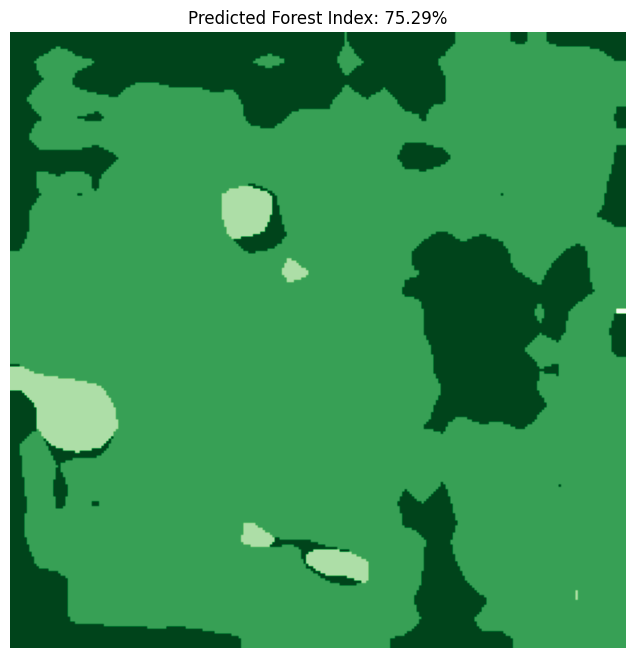

In [21]:
# Forest Index Calculation
# Identify the class index for Forest (update based on your class_dict)
forest_class_index = 2  # Assuming 1 corresponds to Forest

# Count forest pixels in the predicted mask
forest_pixels = np.sum(predicted_mask == forest_class_index)

# Calculate total pixels in the image
total_pixels = predicted_mask.size

# Compute Forest Index
forest_index = forest_pixels / total_pixels
print(f"Forest Index: {forest_index:.2%}")  # Display as a percentage

# Optional: Add the forest index to the visualization title or save the result
plt.figure(figsize=(8, 8))
plt.title(f"Predicted Forest Index: {forest_index:.2%}")
plt.imshow(predicted_mask, cmap='Greens')
plt.axis("off")
plt.show()

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import cv2
from torchvision import models
from torchvision.transforms import functional as TF

# Path to the directory containing images
image_dir = "mu_images/"  # Update this with the actual path to your images
output_csv = "forest_cover_results.csv"  # File to save results

# Path to the trained model
model_path = "archive/deeplabv3_model.pth"

# Load the trained model
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

# Adjust the classifier to match your current task's classes (4)
model.classifier[4] = torch.nn.Conv2d(256, 4, kernel_size=1)  # Replace classifier for 4 classes

# Load pretrained weights, ignoring the mismatched classifier
checkpoint = torch.load(model_path)
filtered_checkpoint = {k: v for k, v in checkpoint.items() if "classifier.4" not in k}
model.load_state_dict(filtered_checkpoint, strict=False)  # Load other weights

model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Class index for forest (update if necessary based on your class_dict)
forest_class_index = 1  # Example: Forest is class index 1

# Function to preprocess an image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))  # Resize to match model input size
    image_tensor = TF.to_tensor(image).unsqueeze(0).to(device)  # Shape: [1, 3, 256, 256]
    return image_tensor

# Function to calculate forest cover for a single image
def calculate_forest_cover(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)['out']
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # Count forest pixels
    forest_pixels = np.sum(predicted_mask == forest_class_index)
    total_pixels = predicted_mask.size
    
    # Calculate forest cover percentage
    forest_cover_percentage = (forest_pixels / total_pixels) * 100
    return forest_cover_percentage

# Process all images in the directory
results = []
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    
    # Skip non-image files
    if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    
    # Preprocess and predict
    image_tensor = preprocess_image(image_path)
    forest_cover = calculate_forest_cover(image_tensor)
    
    # Save result
    results.append({"Image": image_file, "Forest Cover (%)": forest_cover})

    print(f"Processed {image_file}: Forest Cover = {forest_cover:.2f}%")

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(output_csv, index=False)

print(f"Forest cover results saved to {output_csv}")


/tmp/ipykernel_35553/604187057.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Processed 2023.png: Forest Cover = 61.72%
Processed 2022.png: Forest Cover = 75.57%
Processed 2024.png: Forest Cover = 49.60%
Processed 2019.png: Forest Cover = 16.26%
Forest cover results saved to forest_cover_results.csv
